## Calibration executer

Auteurs : Léa Drolet-Roy

Création : 2025-04-04
Dernière modification :

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

from caleabration.calibration import Calibration
from caleabration.charuco import Charucoboard
from caleabration.checkerboard import Checkerboard

np.set_printoptions(precision=4, suppress=True)

### Groundtruth camera parameters

In [2]:
import json

with open('/home/lea/trampo/trampo/cameras_parameters.json', 'r') as f:
    params = json.load(f)

T = {}

for (cam,pos), (cam,ori) in zip(params['camera_position'].items(), params['camera_orientation'].items()):
    pos = np.array(pos)
    ori = np.array(ori)
    R, _ = cv2.Rodrigues(ori.reshape(3, 1))
    t = 1000 * pos.reshape((3,1))
    T[cam] = np.vstack([np.hstack([R, t]), np.array([0,0,0,1])])

np.savez('TransfoCam_world.npz', np.round(list(T.values()), 4))

T_cam1_gt = np.linalg.inv(T['Camera_1'])

mat_cam1 = []
for mat in T.values():
    mat_cam1.append(np.linalg.inv(T_cam1_gt @ mat))

np.savez('TransfoCam_iToCam_1_inv.npz', np.round(mat_cam1, 4))

K_gt = []
pix_size = 0.0055
for (cam, focal) in params['focal_length'].items():
    K_gt.append(np.array([[focal/pix_size, 0, 960],
                          [0, focal/pix_size, 540],
                          [0, 0, 1]], dtype=np.float32))
    
np.savez('K_gt.npz', K_gt)

FileNotFoundError: [Errno 2] No such file or directory: '/home/lea/trampo/trampo/cameras_parameters.json'

## Initial parameters

In [9]:
# Paramètres Spot
CHECKERBOARD = (9,4)
square_size = 112
marker_size = 86
legacy = True

""" # Paramètres grand simul
CHECKERBOARD = (5,4)
square_size = 230
marker_size = 172
legacy = True """

""" # Paramètres petit simul
CHECKERBOARD = (4,5)
square_size = 150
marker_size = 112
legacy = False """

image_size = (1280, 720) #(1080, 1920)

aruco_name = cv2.aruco.DICT_4X4_50

# create Charurco board object
Board = Charucoboard(CHECKERBOARD, square_size, marker_size, aruco_name, legacy)

# validate board creation
Board.create_and_save_new_board()

# create Calibration object
Calib = Calibration(Board, image_size)

#cams = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463'] #
#cams = ['c11140', 'c11141', 'c11458', 'c11459', 'c11461', 'c11462', 'c11463']
#cams = ['c1', 'c2', 'c3', 'c5', 'c6', 'c7', 'c8']
cams = ['Camera_1'] #, 'Camera_2', 'Camera_3', 'Camera_4', 'Camera_5', 'Camera_6', 'Camera_7', 'Camera_8']

time_threshold = 15

path = '/media/lea/store/Images/RealSense_RGBD'
#path = '/media/lea/store/Images/CalibrationAtrium2'
calib_dir = os.path.join(path, 'corners_found')

### Test board detection

IDs détectés : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


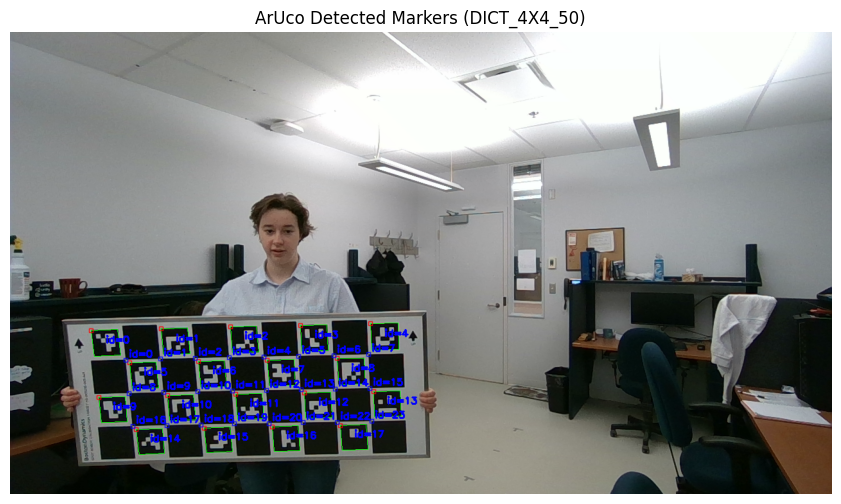

In [18]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt

# Chargement de l'image
image = cv2.imread('/media/lea/store/Images/RealSense_RGBD/intrinsics/Camera_1/capture_rgb_1744932374.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Choix du dictionnaire (commence par 4x4_50)
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard(CHECKERBOARD, square_size, marker_size, aruco_dict)
board.setLegacyPattern(legacy)
parameters = aruco.DetectorParameters()

# Détection des marqueurs
markerCorners, markerIds, reject  = cv2.aruco.detectMarkers(gray, aruco_dict)
retval, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(markerCorners, markerIds, gray, board)

img_with_charuco_corners = image.copy()
img_with_charuco_corners = cv2.aruco.drawDetectedMarkers(img_with_charuco_corners, markerCorners, markerIds)

# Impression des IDs détectés
if charucoIds is not None:
    print("IDs détectés :", charucoIds.flatten())
    img_with_charuco_corners = cv2.aruco.drawDetectedCornersCharuco(img_with_charuco_corners, charucoCorners, charucoIds)
else:
    print("Aucun coin détecté.")
                         
# Affichage avec matplotlib
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_with_charuco_corners, cv2.COLOR_BGR2RGB))
plt.title("ArUco Detected Markers (DICT_4X4_50)")
plt.axis("off")
plt.show()

### Save images with detections

Images saving...
Coverage for cam Camera_1: 60.85%
Saved 114 valid frames.


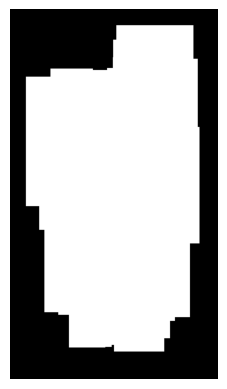

In [16]:
valid_frame_count, total_area_covered, mask_covered = Calib.saveImagesBoard(path, 'png', skip=1)

for mask in mask_covered:
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

### Intrinsic calibration

In [17]:
# Try setting an initial camera matrix
w,h = image_size
focal_length = 654 # Approximate focal length
camera_matrix_init = np.array([
    [focal_length, 0, w / 2],
    [0, focal_length, h / 2],
    [0, 0, 1]], dtype=np.float32)

ret, C, S, D, K = Board.calibrate_intrinsics(calib_dir, cams) #, image_size, camera_matrix_init)

K = np.array(K)
np.savez('Intrinsics_K_reals.npz', K)

D = np.array(D)
np.savez('Intrinsics_D_reals.npz', D)


Calibration completed for camera: Camera_1
Error: 0.2437
Camera Matrix:
 [[641.7114   0.     643.5294]
 [  0.     641.5311 357.3459]
 [  0.       0.       1.    ]]
Distortion Coefficients:
 [[-0.0494  0.0551  0.001   0.0011 -0.0154]]


In [ ]:
K = np.load('saved_params/K_gt.npz')['arr_0']
D = np.load('Intrinsics_D_blenderbig.npz')['arr_0']
D = np.zeros((D.shape))

print(f'Intrinsics: \n{K[0]} \n{K[1]} \n{K[2]} \n{K[3]} \n{K[4]} \n{K[5]} \n{K[6]} \n{K[7]}')

Intrinsics: 
[[2181.818    0.     960.   ]
 [   0.    2181.818  540.   ]
 [   0.       0.       1.   ]] 
[[2181.818    0.     960.   ]
 [   0.    2181.818  540.   ]
 [   0.       0.       1.   ]] 
[[1236.3636    0.      960.    ]
 [   0.     1236.3636  540.    ]
 [   0.        0.        1.    ]] 
[[2181.818    0.     960.   ]
 [   0.    2181.818  540.   ]
 [   0.       0.       1.   ]] 
[[1236.3636    0.      960.    ]
 [   0.     1236.3636  540.    ]
 [   0.        0.        1.    ]] 
[[1236.3636    0.      960.    ]
 [   0.     1236.3636  540.    ]
 [   0.        0.        1.    ]] 
[[2181.818    0.     960.   ]
 [   0.    2181.818  540.   ]
 [   0.       0.       1.   ]] 
[[1236.3636    0.      960.    ]
 [   0.     1236.3636  540.    ]
 [   0.        0.        1.    ]]


In [ ]:
Calib.saveStereoData(path, cams)

Camera_1 Camera_2 0
Camera_1 Camera_3 4
Camera_1 Camera_4 0
Camera_1 Camera_5 0
Camera_1 Camera_6 0
Camera_1 Camera_7 0
Camera_1 Camera_8 16
Camera_2 Camera_3 36
Camera_2 Camera_4 2
Camera_2 Camera_5 0
Camera_2 Camera_6 0
Camera_2 Camera_7 0
Camera_2 Camera_8 0
Camera_3 Camera_4 5
Camera_3 Camera_5 0
Camera_3 Camera_6 0
Camera_3 Camera_7 0
Camera_3 Camera_8 2
Camera_4 Camera_5 5
Camera_4 Camera_6 4
Camera_4 Camera_7 0
Camera_4 Camera_8 0
Camera_5 Camera_6 4
Camera_5 Camera_7 3
Camera_5 Camera_8 1
Camera_6 Camera_7 10
Camera_6 Camera_8 2
Camera_7 Camera_8 2


In [ ]:
with open('stereo_data.pkl', 'rb') as f:
    stereo_images = pickle.load(f)

In [ ]:
for camL in cams:
    
    Left_Params = {}
    Left_Params['Intrinsic'] = K[cams.index(camL)]
    Left_Params['Distortion'] = D[cams.index(camL)]

    for camR in cams[cams.index(camL)+1:]:
        print(camL, camR)

        Left_corners = [stereo_images['Charuco_Corners'][i] for i in range(0, len(stereo_images['Corners']), 2) if stereo_images['Camera'][i] == camL and stereo_images['Camera'][i+1] == camR]
        Right_corners = [stereo_images['Charuco_Corners'][i] for i in range(1, len(stereo_images['Corners']), 2) if stereo_images['Camera'][i-1] == camL and stereo_images['Camera'][i] == camR]
        
        Left_ids = [stereo_images['Ids'][i] for i in range(0, len(stereo_images['Corners']), 2) if stereo_images['Camera'][i] == camL and stereo_images['Camera'][i+1] == camR]
        Right_ids = [stereo_images['Ids'][i] for i in range(1, len(stereo_images['Corners']), 2) if stereo_images['Camera'][i-1] == camL and stereo_images['Camera'][i] == camR]
        
        Right_Params = {}
        
        if len(Left_corners) >= 1 and len(Right_corners) >= 1:

            Right_Params['Intrinsic'] = K[cams.index(camR)]
            Right_Params['Distortion'] = D[cams.index(camR)]
            
            ret, Stereo_Params = Calib.StereoCalibration(Left_Params, Right_Params, Left_corners, Left_ids, Right_corners, Right_ids)
            if ret:
                print('Transformation Matrix:')
                print(Stereo_Params['Transformation'])
                print(Stereo_Params['MeanError'])
                print(Stereo_Params['Nobj'], '\n')

                Calib.SaveParameters(camL, camR, Stereo_Params, Left_Params, Right_Params)
            else:
                print('Not enough corners', '\n')
        else:
            print('Not enough images', '\n')

Camera_1 Camera_2
Not enough images 

Camera_1 Camera_3
Transformation Matrix:
[[    0.1522     0.9873    -0.0462   583.0867]
 [    0.4395    -0.0257     0.8979 -1293.743 ]
 [    0.8852    -0.157     -0.4379  6809.3895]
 [    0.         0.         0.         1.    ]]
1.4801084525709733
36 

Camera_1 Camera_4
Not enough images 

Camera_1 Camera_5
Not enough images 

Camera_1 Camera_6
Not enough images 

Camera_1 Camera_7
Not enough images 

Camera_1 Camera_8
Transformation Matrix:
[[    0.8373    -0.4752    -0.2705  1993.053 ]
 [    0.5233     0.5531     0.6482 -2936.3997]
 [   -0.1584    -0.6843     0.7118   105.9669]
 [    0.         0.         0.         1.    ]]
4.339773401969817
174 

Camera_2 Camera_3
Transformation Matrix:
[[    0.7846     0.5948     0.175   -636.7662]
 [   -0.5588     0.5561     0.6152 -2623.9459]
 [    0.2686    -0.5805     0.7687  2325.5523]
 [    0.         0.         0.         1.    ]]
5.723626203674581
323 

Camera_2 Camera_4
Transformation Matrix:
[[    0

In [ ]:
"""c1_c3 = np.load('c1_c3_parameters.npz')['Transformation']
c1_c5 = np.load('c1_c5_parameters.npz')['Transformation']
c1_c7 = np.load('c1_c7_parameters.npz')['Transformation']
c2_c7 = np.load('c2_c7_parameters.npz')['Transformation']
c3_c6 = np.load('c3_c6_parameters.npz')['Transformation']
c3_c7 = np.load('c3_c7_parameters.npz')['Transformation']
c5_c8 = np.load('c5_c8_parameters.npz')['Transformation']
c6_c8 = np.load('c6_c8_parameters.npz')['Transformation'] """

c1_c3 = np.load('Camera_1_Camera_3_parameters.npz')['Transformation']
c1_c8 = np.load('Camera_1_Camera_8_parameters.npz')['Transformation']
c2_c3 = np.load('Camera_2_Camera_3_parameters.npz')['Transformation']
c2_c4 = np.load('Camera_2_Camera_4_parameters.npz')['Transformation']
c3_c4 = np.load('Camera_3_Camera_4_parameters.npz')['Transformation']
c3_c8 = np.load('Camera_3_Camera_8_parameters.npz')['Transformation']
c4_c5 = np.load('Camera_4_Camera_5_parameters.npz')['Transformation']
c4_c6 = np.load('Camera_4_Camera_6_parameters.npz')['Transformation']
c5_c7 = np.load('Camera_5_Camera_7_parameters.npz')['Transformation']
c5_c6 = np.load('Camera_5_Camera_6_parameters.npz')['Transformation']
c6_c7 = np.load('Camera_6_Camera_7_parameters.npz')['Transformation']
c6_c8 = np.load('Camera_6_Camera_8_parameters.npz')['Transformation']
c7_c8 = np.load('Camera_7_Camera_8_parameters.npz')['Transformation']

Tcam1 = np.eye((4))
Tcam3 = c1_c3
Tcam8 = c1_c8
Tcam2 = c1_c3 @ np.linalg.inv(c2_c3)
Tcam4 = Tcam2 @ c2_c4
Tcam5 = Tcam4 @ c4_c5
Tcam6 = Tcam4 @ c4_c6
Tcam7 = Tcam5 @ c5_c7

projMat = [Tcam1, Tcam2, Tcam3, Tcam4, Tcam5, Tcam6, Tcam7, Tcam8]

for mat in projMat:
    print(mat)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[    0.6985     0.4356    -0.5677  3491.087 ]
 [    0.4867     0.2924     0.8232 -2130.9016]
 [    0.5246    -0.8513    -0.0077  4927.5138]
 [    0.         0.         0.         1.    ]]
[[    0.1522     0.9873    -0.0462   583.0867]
 [    0.4395    -0.0257     0.8979 -1293.743 ]
 [    0.8852    -0.157     -0.4379  6809.3895]
 [    0.         0.         0.         1.    ]]
[[  -0.2725    0.7059   -0.6537   99.342 ]
 [   0.9126    0.405     0.0569 4876.987 ]
 [   0.3049   -0.5811   -0.7546 7598.5268]
 [   0.        0.        0.        1.    ]]
[[   -0.5528     0.7113     0.4341 -8118.3258]
 [   -0.3803     0.2481    -0.891   7973.6689]
 [   -0.7414    -0.6576     0.1333  5696.173 ]
 [    0.         0.         0.         1.    ]]
[[   -0.4457     0.7801     0.439  -8683.2818]
 [    0.0905     0.5272    -0.8449 10022.332 ]
 [   -0.8906    -0.3369    -0.3056  6345.0074]
 [    0.         0.         0.         1.    ]]
[[    0.24

In [ ]:
## PSO for extrinsic parameters (with Bundle adjustment)
# Constants
num_cameras = 7
num_params_per_cam = 6
total_params = num_cameras * num_params_per_cam
n_particles = 60  # Number of particles
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7} #{'c1': 2.05, 'c2': 2.05, 'w': 0.729} # PSO Hyperparameters

projMat = np.load('Extrinsics_optimized_42_small.npz')['arr_0']

init_params = []
for mat in projMat[1:]:
    rvec, _ = cv2.Rodrigues(mat[0:3,0:3])
    rvec = rvec.squeeze()
    params = [rvec[0], rvec[1], rvec[2], mat[0,3], mat[1,3], mat[2,3]]
    init_params.extend(params)

init_params = np.array(init_params, dtype=np.float64)
init_pos = np.tile(init_params, (n_particles,1))
print(init_params.shape)
print(init_pos.shape)

# Define parameter bounds
lower_bounds = [-2*np.pi, -2*np.pi, -2*np.pi, -10000, -10000, -10000]
upper_bounds = [2*np.pi, 2*np.pi, 2*np.pi, 20000, 20000, 20000]

param_bounds = (np.tile(lower_bounds, num_cameras), np.tile(upper_bounds, num_cameras))
print(param_bounds[0].shape)

print(np.all(param_bounds[0] <= init_pos[0]))
print(np.all(init_pos[0] <= param_bounds[1]))

(42,)
(60, 42)
(42,)
True
True


In [ ]:
board = Board.type

def fun(params):
    errors = np.empty((n_particles,))
    params = np.array(params)

    for n in range(n_particles):
        projMat = np.empty((num_cameras+1, 3, 4))
        projMat[0] = np.hstack((np.eye((3)), np.zeros((3,1))))

        for cam_idx in range(num_cameras):
            cam_params = params[n][cam_idx * num_params_per_cam : (cam_idx + 1) * num_params_per_cam]
            r1, r2, r3, t1, t2, t3 = cam_params
            rvec = np.array([r1, r2, r3])
            R, _ = cv2.Rodrigues(rvec)
            t = np.array([t1, t2, t3]).reshape((3,1))
            projMat[cam_idx+1] = np.hstack((R, t))  #[cam_idx+1]

        RMSE = {c:[] for c in range(8)}
        # Loop on stereo images checkerboard points
        for i in range(0, len(stereo_images['Camera']) - 1, 2):
            j = i+1 # stereo image is the next one

            pts1_im = stereo_images['Charuco_Corners'][i].squeeze()
            pts2_im = stereo_images['Charuco_Corners'][j].squeeze()

            c1 = cams.index(stereo_images['Camera'][i])
            c2 = cams.index(stereo_images['Camera'][j])

            undist_pts1 = cv2.undistortPoints(pts1_im.reshape(-1,1,2), K[c1], D[c1]).reshape(-1, 2)  # Shape (2, N)
            undist_pts2 = cv2.undistortPoints(pts2_im.reshape(-1,1,2), K[c2], D[c2]).reshape(-1, 2)  # Shape (2, N)

            if board == 'charuco':
                Lids = stereo_images['Ids'][i].squeeze()
                Rids = stereo_images['Ids'][j].squeeze()

                obj_pts, img_pts_l, img_pts_r, common_ids = Board.getObjectImagePoints(undist_pts1, Lids, undist_pts2, Rids)
                img_pts_l, img_pts_r = img_pts_l.squeeze(), img_pts_r.squeeze()

                ids_to_keepL = [list(Lids).index(t) for t in common_ids]
                ids_to_keepR = [list(Rids).index(t) for t in common_ids]
                pts1_im, pts2_im = pts1_im[ids_to_keepL], pts2_im[ids_to_keepR]

            elif board == 'checker':
                img_pts_l, img_pts_r = undist_pts1, undist_pts2

            # Perform triangulation
            pts_4d = cv2.triangulatePoints(projMat[c1], projMat[c2], img_pts_l.T, img_pts_r.T)
            points_3d = pts_4d[:3, :] / pts_4d[3, :]  # Shape (3, N)
            points_3d = points_3d.T  # Shape (N, 3)

            # Compute RMSE for both cameras
            rmse1 = Calib.compute_rmse(pts1_im, points_3d, projMat[c1], K[c1], D[c1])
            rmse2 = Calib.compute_rmse(pts2_im, points_3d, projMat[c2], K[c2], D[c2])

            RMSE[c1].append(rmse1)
            RMSE[c2].append(rmse2)

        # Per-camera mean RMSE
        rmse_mean = []
        for _, rmse in RMSE.items():
            rmse_mean.append(np.mean(rmse))

        errors[n] = np.mean(rmse_mean) + 0.1 * np.max(rmse_mean)   # OPTIONAL: add max error to cost function
    
    return errors.tolist()

2025-04-17 14:30:21,200 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=49 
2025-04-17 14:39:47,947 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 48.96052932739258, best pos: [   -1.4278    -0.4867     0.1392  1420.0375 -2203.3739  4932.9459
    -1.145     -0.0675    -0.1631   628.6467 -1201.2424  5349.3773
    -1.7735    -1.7232     1.2484   101.7035  4730.2835  7833.5104
     0.8689     1.5333    -1.8315 -8121.4035  7572.9139  4225.507
     0.1381     1.346     -2.1944 -9999.861  10271.1573  6304.1872
     0.0355    -0.136     -1.1395 -5456.9589 -1219.036   2027.0054
    -0.2789     0.073      0.6433  1505.1535 -2136.0206 -2256.9616]


Best Reprojection Error: 48.96052932739258 pixels


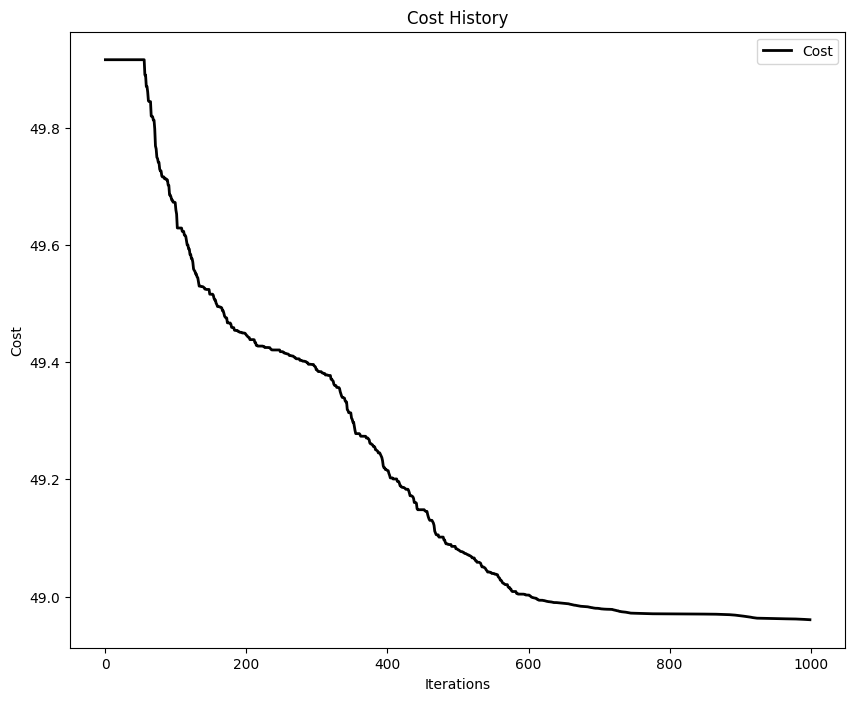

In [ ]:
# Run PSO to optimize calibration parameters
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=total_params, options=options, bounds=param_bounds, init_pos=init_pos)
best_error, best_params = optimizer.optimize(fun, iters = 1000)
print(f"Best Reprojection Error: {best_error} pixels")

# Extract optimized parameters for each camera
optimized_params = np.split(best_params, num_cameras)

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [ ]:
extrinsics = []
extrinsics.append(np.hstack((np.eye((3)), np.zeros((3,1)))))

for cam_idx in range(num_cameras):
    r1, r2, r3, t1, t2, t3 = optimized_params[cam_idx]
    rvec = np.array([r1,r2,r3], dtype=np.float64)
    R, _ = cv2.Rodrigues(rvec)
    t = np.array([t1,t2,t3], dtype=np.float64).reshape((3,1))

    optimized_camera_matrix = np.hstack((R,t))
    extrinsics.append(optimized_camera_matrix)

for cam_idx, cam_mat in enumerate(extrinsics):
    print(f"Camera {cam_idx+1} Optimized Camera Matrix:\n", cam_mat)

np.savez('Extrinsics_optimized_42_small.npz', extrinsics)

Camera 1 Optimized Camera Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
Camera 2 Optimized Camera Matrix:
 [[    0.8946     0.1941    -0.4026  1420.0375]
 [    0.3776     0.1534     0.9132 -2203.3739]
 [    0.239     -0.9689     0.0639  4932.9459]]
Camera 3 Optimized Camera Matrix:
 [[    0.9861     0.1635     0.03     628.6467]
 [   -0.0945     0.4027     0.9104 -1201.2424]
 [    0.1367    -0.9006     0.4125  5349.3773]]
Camera 4 Optimized Camera Matrix:
 [[  -0.1399    0.6058   -0.7832  101.7035]
 [   0.933    -0.1842   -0.3091 4730.2835]
 [  -0.3315   -0.774    -0.5394 7833.5104]]
Camera 5 Optimized Camera Matrix:
 [[   -0.6121     0.7832    -0.1091 -8121.4035]
 [   -0.0303    -0.1611    -0.9865  7572.9139]
 [   -0.7902    -0.6005     0.1224  4225.507 ]]
Camera 6 Optimized Camera Matrix:
 [[   -0.84       0.5063     0.1948 -9999.861 ]
 [   -0.4031    -0.3423    -0.8487 10271.1573]
 [   -0.3631    -0.7915     0.4916  6304.1872]]
Camera 7 Optimized Camera Matrix:
 [[    0.410

## Cumulative error on matrices multiplication (Total transfo = I ?) 

In [ ]:
T = []

for mat in extrinsics:
    M = np.vstack((mat, np.array([0,0,0,1])))
    T.append(M)

T_next = []
for i in range(len(T) - 1):
    T_next.append(np.linalg.inv(T[i]) @ T[i+1])

T5_calc = T_next[0] @ T_next[1] @ T_next[2] @ T_next[3]

print('T5 calc: \n', T5_calc)
print('T5: \n', T[4])

I_calc = T5_calc @ np.linalg.inv(T[4])
print('Cumulative error: \n', np.abs(I_calc - np.eye(4)))

T5 calc: 
 [[  -0.5801   -0.1367   -0.803  2111.6382]
 [  -0.5172    0.8234    0.2335 -691.3284]
 [   0.6293    0.5508   -0.5483 9494.4308]
 [   0.        0.        0.        1.    ]]
T5: 
 [[  -0.5801   -0.1367   -0.803  2111.6382]
 [  -0.5172    0.8234    0.2335 -691.3284]
 [   0.6293    0.5508   -0.5483 9494.4308]
 [   0.        0.        0.        1.    ]]
Cumulative error: 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


## 2D visualization of original and projected points onto images

In [ ]:
def draw_circles(img, pts_2d_original, pts_2d_projected, text=True):

    pts_2d_original = pts_2d_original.reshape(-1,2)
    pts_2d_projected = pts_2d_projected.reshape(-1,2)
    
    for p in range(len(pts_2d_original)):
        x_orig, y_orig = map(int, pts_2d_original[p])  # Original 2D point
        cv2.circle(img, (x_orig, y_orig), 8, (255, 0, 0), -1)

        if pts_2d_projected is not None:
            x_proj, y_proj = map(int, pts_2d_projected[p])  # Reprojected 3D point
            cv2.circle(img, (x_proj, y_proj), 8, (0, 255, 0), -1)
            cv2.line(img, (x_orig, y_orig), (x_proj, y_proj), (0, 255, 255), 2)

        if text:
            # Add labels
            cv2.putText(img, str(p + 1), (x_orig + 10, y_orig), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, (255, 0, 0), 2, cv2.LINE_AA)
            cv2.putText(img, str(p + 1), (x_proj + 10, y_proj), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, (0, 255, 0), 2, cv2.LINE_AA)
        
    return img

In [ ]:
height = 8 * 1000
length = 3.1 * 1000
width = 1.2 * 1000

spacing = 1

X = np.arange(-length/2, length/2 + spacing, spacing, dtype=np.int64)
Y = np.arange(-width/2, width/2 + spacing, spacing, dtype=np.int64)
Z = np.arange(0, height + spacing, spacing, dtype=np.int64)

# Stack to get a 3D array of shape (len(x), len(y), len(z), 3)
volume = [X,Y,Z]
mask = np.zeros((len(X), len(Y), len(Z)), dtype=bool)

def addToVolume(volume, mask, points):
    for pt in points:
        x = np.abs(X - pt[0]).argmin()
        y = np.abs(Y - pt[1]).argmin()
        z = np.abs(Z - pt[2]).argmin()
        mask[x,y,z] = 1

    return mask

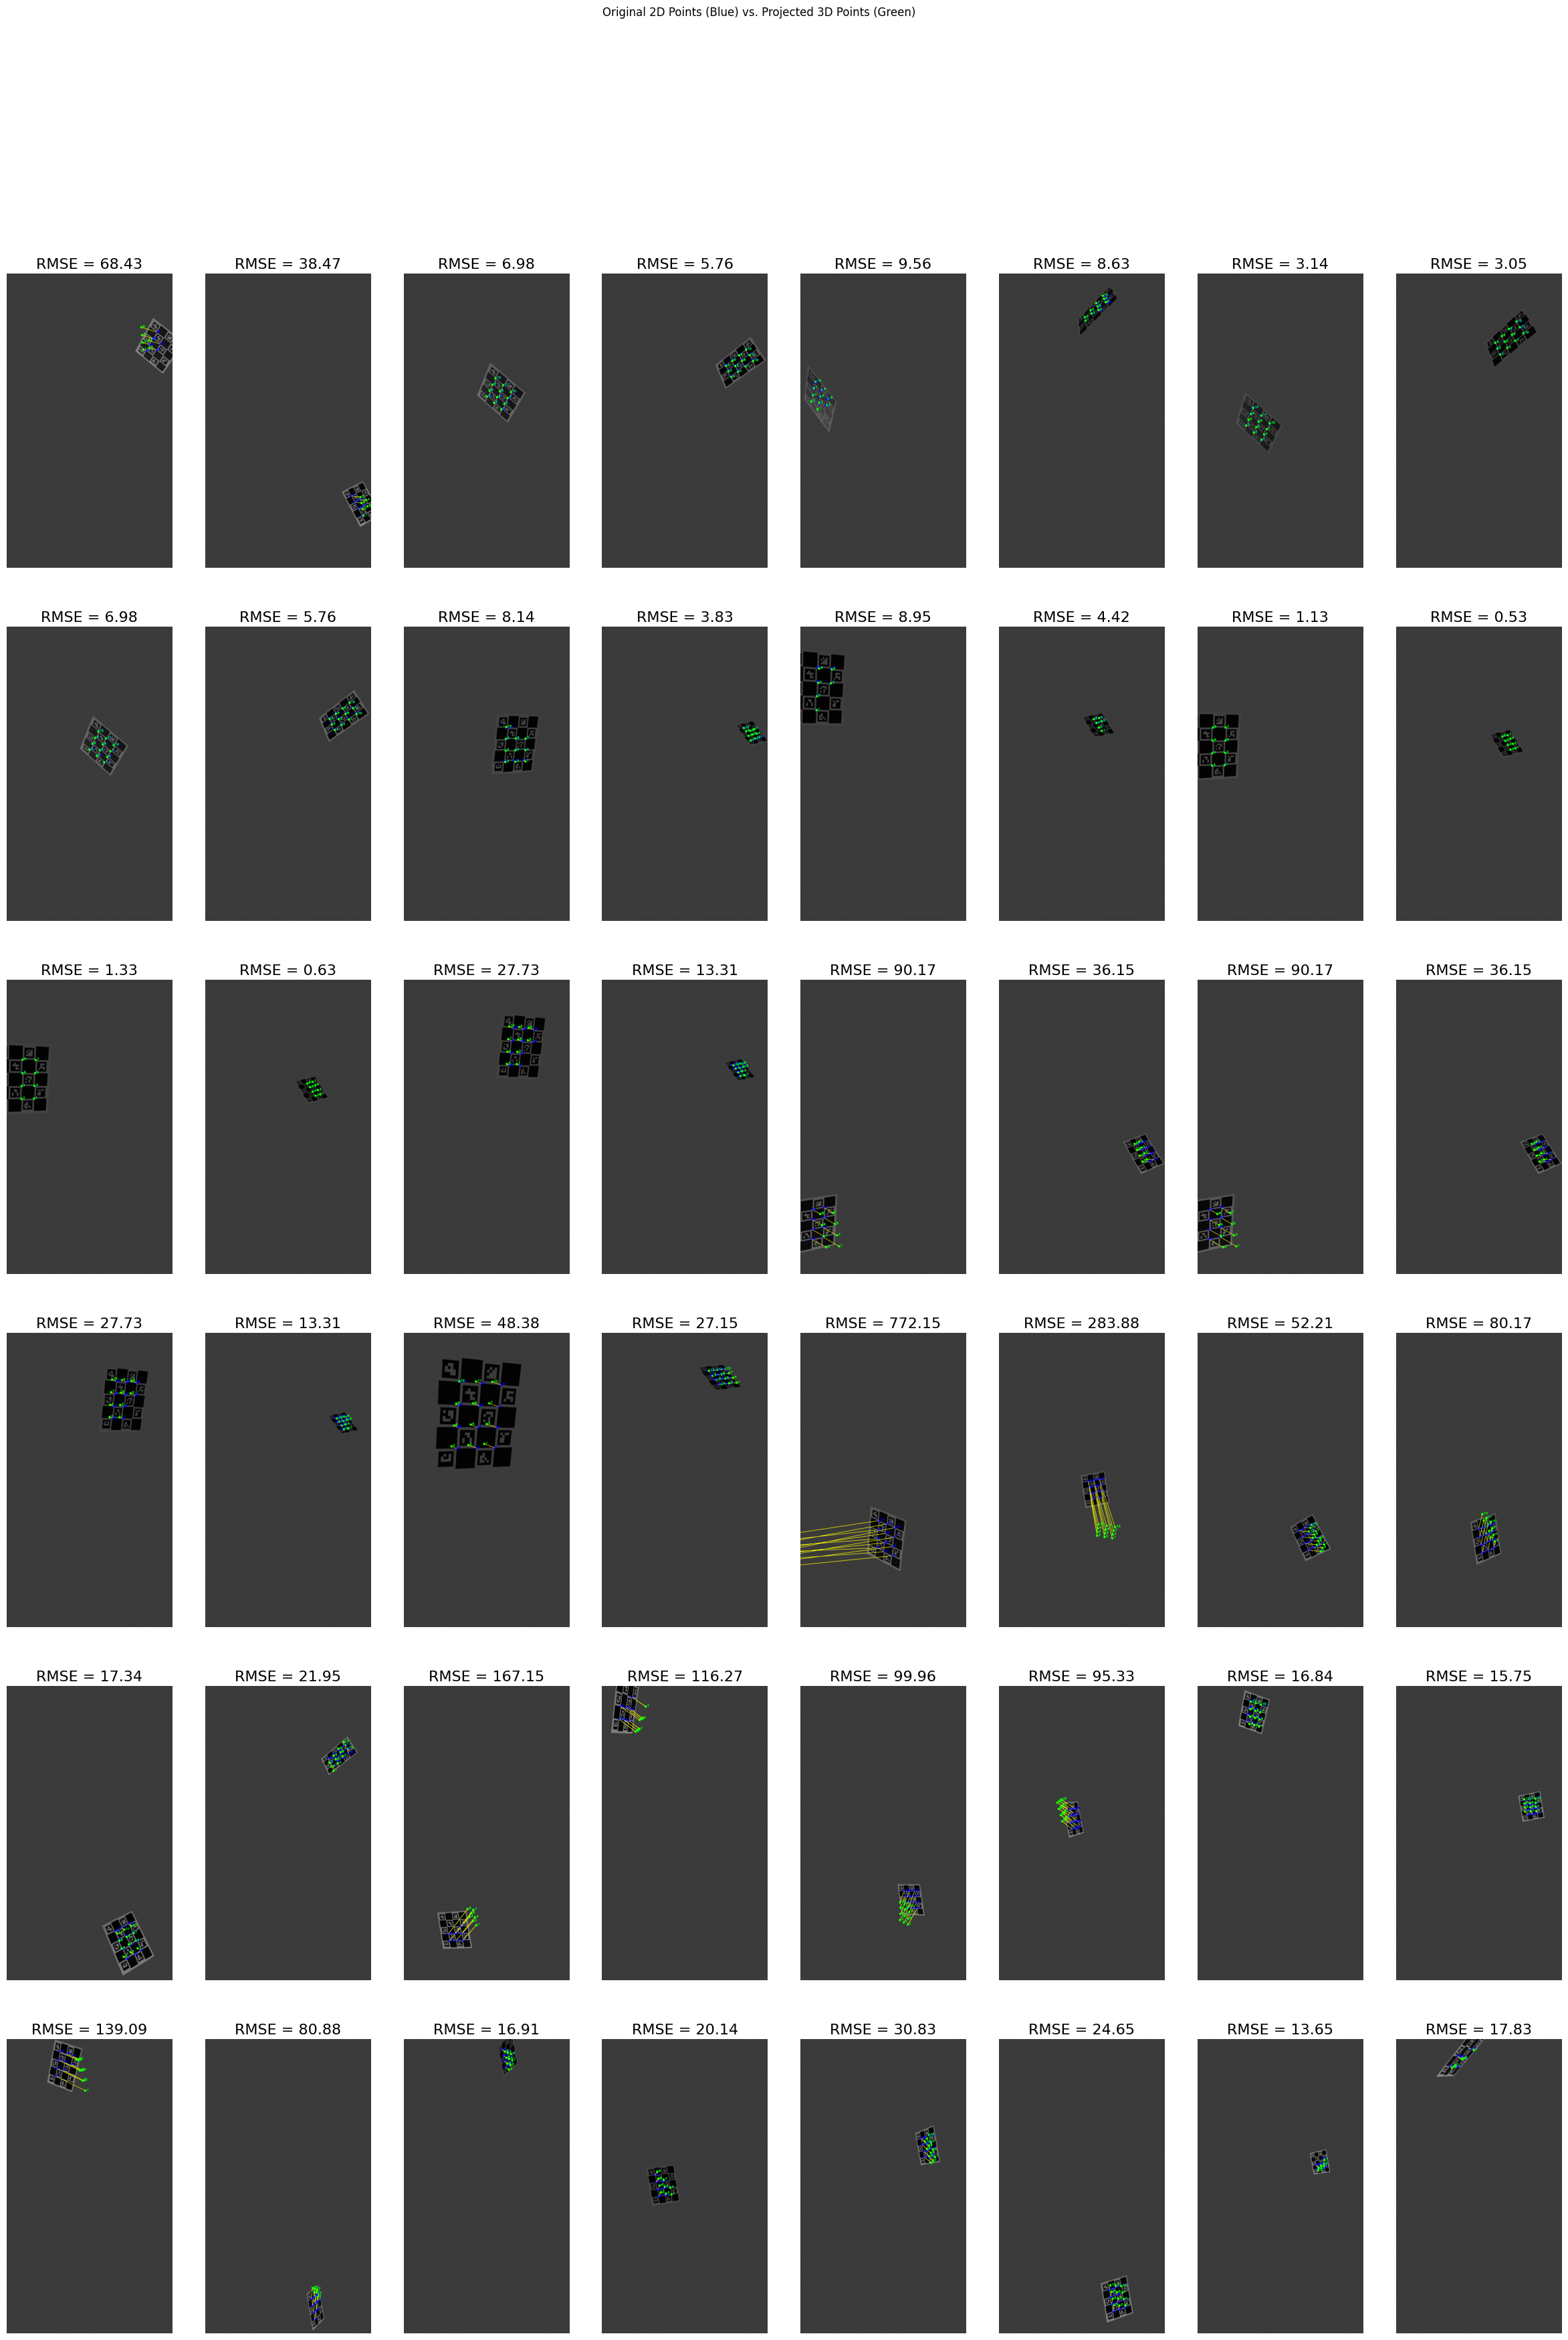

Camera_1-Camera_3 55.559364
Camera_1-Camera_8 4.3971734
Camera_2-Camera_3 17.245138
Camera_2-Camera_4 282.44113
Camera_3-Camera_4 43.29843
Camera_3-Camera_8 19.646072
Camera_4-Camera_5 64.64848
Camera_4-Camera_6 59.544785
Camera_5-Camera_6 23.138866
Camera_5-Camera_7 139.26662
Camera_5-Camera_8 23.811253
Camera_6-Camera_7 33.25683
Camera_6-Camera_8 127.37872
Camera_7-Camera_8 28.351482
RMSE total -- Mean: 65.85602569580078, Median: 38.27762985229492


In [ ]:
projMat = extrinsics

RMSE = []
rmse_per_cam = {}
for cam1 in cams:
    for cam2 in cams[cams.index(cam1):]:
        rmse_per_cam.update({f'{cam1}-{cam2}': []})

fig, axs = plt.subplots(6,8, figsize=(30, 40))
axs = axs.flat
k = 0

points_array = []

for i in range(0, len(stereo_images['Camera']) - 1, 2):
    j = i+1 # stereo image is the next one

    pts1_im = stereo_images['Charuco_Corners'][i].squeeze()
    pts2_im = stereo_images['Charuco_Corners'][j].squeeze()

    Lids = stereo_images['Ids'][i].squeeze()
    Rids = stereo_images['Ids'][j].squeeze()

    c1 = cams.index(f'{stereo_images['Camera'][i]}')
    c2 = cams.index(f'{stereo_images['Camera'][j]}')
    
    undist_pts1 = cv2.undistortPoints(pts1_im, K[c1], D[c1]).reshape(-1, 2)  # Shape (2, N)
    undist_pts2 = cv2.undistortPoints(pts2_im, K[c2], D[c2]).reshape(-1, 2)  # Shape (2, N)

    obj_pts, img_pts_l, img_pts_r, common_ids = Board.getObjectImagePoints(undist_pts1, Lids, undist_pts2, Rids)
    img_pts_l, img_pts_r = img_pts_l.squeeze(), img_pts_r.squeeze()

    ids_to_keepL = [list(Lids).index(t) for t in common_ids]
    ids_to_keepR = [list(Rids).index(t) for t in common_ids]

    # Perform triangulation
    pts_4d = cv2.triangulatePoints(projMat[c1], projMat[c2], img_pts_l.T, img_pts_r.T)
    points_3d = pts_4d[:3, :] / pts_4d[3, :]  # Shape (3, N)
    points_3d = points_3d.T  # Shape (N, 3)

    points_array.append(points_3d)

    """ points_4d_world = (T_cam1_gt @ pts_4d)
    points_3d_world = (points_4d_world[:3, :] / points_4d_world[3, :]).T
    mask = addToVolume(volume, mask, points_3d_world) """

    img_path1 = os.path.join(calib_dir, stereo_images['Camera'][i], stereo_images['Name'][i])
    img_path2 = os.path.join(calib_dir, stereo_images['Camera'][j], stereo_images['Name'][j])

    # Visualize original and reprojected points (image 1)
    img = cv2.imread(img_path1)

    pts_2d_projected, _ = cv2.projectPoints(points_3d, projMat[c1][0:3,0:3], projMat[c1][0:3,3], K[c1], D[c1])
    pts_2d_projected = pts_2d_projected.squeeze()
    rmse1 = Calib.compute_rmse(pts1_im[ids_to_keepL], points_3d, projMat[c1], K[c1], D[c1])

    if i % 8 == 0 and k < len(axs):
        img = draw_circles(img, pts1_im[ids_to_keepL], pts_2d_projected)
        axs[k].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[k].axis('off')
        axs[k].set_title(f'RMSE = {rmse1:.2f}', fontsize=16)

    # Visualize original and reprojected points (image 2)
    img = cv2.imread(img_path2)
    
    pts_2d_projected, _ = cv2.projectPoints(points_3d, projMat[c2][0:3,0:3], projMat[c2][0:3,3], K[c2], D[c2])
    pts_2d_projected = pts_2d_projected.squeeze()
    rmse2 = Calib.compute_rmse(pts2_im[ids_to_keepR], points_3d, projMat[c2], K[c2], D[c2])

    if i % 8 == 0 and k < len(axs):
        img = draw_circles(img, pts2_im[ids_to_keepR], pts_2d_projected)
        axs[k+1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[k+1].axis('off')
        axs[k+1].set_title(f'RMSE = {rmse2:.2f}', fontsize=16)
        k += 2

    rmse_per_cam[f'{cams[c1]}-{cams[c2]}'] += [rmse1, rmse2]

fig.suptitle("Original 2D Points (Blue) vs. Projected 3D Points (Green)")
#fig.tight_layout()
plt.show()
plt.close()

mean_RMSE = []
for key, vals in rmse_per_cam.items():
    if not np.isnan(vals).all():
        m = np.mean(vals)
        print(key, m)
        mean_RMSE.append(m)

print(f'RMSE total -- Mean: {np.mean(mean_RMSE)}, Median: {np.median(mean_RMSE)}')

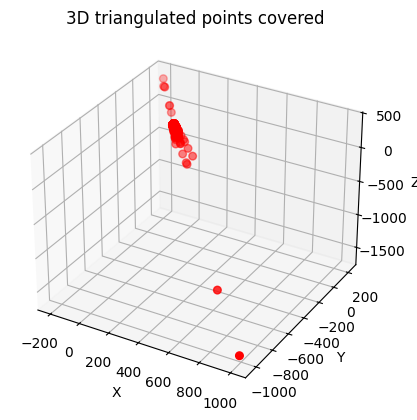

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

points_array = np.vstack(points_array)
points_array_m = points_array / 1000

ax.scatter(points_array_m[:, 0], points_array_m[:, 1], points_array_m[:, 2],
           c='red', marker='o', s=30)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D triangulated points covered')
plt.show()
